**Check Python version. This notebook is implemented for Python 2.7.x. Not all cells may work in other versions of Python.**

In [3]:
import platform
print(platform.python_version())

3.6.7


### Predicting Customer Churn in Telco
In this notebook you will learn how to build a predictive model with scikit-learn API and deploy it for scoring in Machine Learning (ML). 

This notebook walks you through these steps:
- Build a model with **scikit-learn** API
- Save the model in the ML repository
- Create a Deployment in ML (via UI)
- Test the model (via UI)
- Test the model (via REST API)

### Step 1: Review Use Case
The analytics use case implemented in this notebook is telco churn. While it's a simple use case, it implements all steps from the CRISP-DM methodolody, which is the recommended best practice for implementing predictive analytics. 
![CRISP-DM](https://raw.githubusercontent.com/yfphoon/dsx_demo/master/crisp_dm.png)

The analytics process starts with defining the business problem and identifying the data that can be used to solve the problem. For Telco churn, we use demographic and historical transaction data. We also know which customers have churned, which is the critical information for building predictive models. In the next step, we use visual APIs for data understanding and complete some data preparation tasks. In a typical analytics project data preparation will include more steps (for example, formatting data or deriving new variables). 

Once the data is ready, we can build a predictive model. In our example we are using the scikit-learn Random Forrest classification model. Classification is a statistical technique which assigns a "class" to each customer record (for our use case "churn" or "no churn"). Classification models use historical data to come up with the logic to predict "class", this process is called model training. After the model is created, it's usually evaluated using another data set. 

Finally, if the model's accuracy meets the expectations, it can be deployed for scoring. Scoring is the process of applying the model to a new set of data. For example, when we receive new transactional data, we can score the customer for the risk of churn.  

We also developed a sample Python Flask application to illustrate deployment: http://predictcustomerchurn.mybluemix.net/. This application implements the REST client call to the model.

### Step 2: Set up environment

In [8]:


import os, pandas as pd
# Add asset from file system
data = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/customer_churn.csv')
data.head()



,ID,CHURN,Gender,Status,Children,Est Income,Car Owner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan
0,1,T,F,S,1.0,38000.00,N,24.393333,23.56,0.0,206.08,0.0,CC,Budget,Intnl_discount,229.64,3.0
1,6,F,M,M,2.0,29616.00,N,49.426667,29.78,0.0,45.50,0.0,CH,FreeLocal,Standard,75.29,2.0
2,8,F,M,M,0.0,19732.80,N,50.673333,24.81,0.0,22.44,0.0,CC,FreeLocal,Standard,47.25,3.0
3,11,F,M,S,2.0,96.33,N,56.473333,26.13,0.0,32.88,1.0,CC,Budget,Standard,59.01,1.0
4,14,F,F,M,2.0,52004.80,N,25.140000,5.03,0.0,23.11,0.0,CH,Budget,Intnl_discount,28.14,1.0


In [9]:
#rename some columns
data=data.rename(columns={'Est Income': 'EstIncome', 'Car Owner': 'CarOwner'})
data.head()

,ID,CHURN,Gender,Status,Children,EstIncome,CarOwner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan
0,1,T,F,S,1.0,38000.00,N,24.393333,23.56,0.0,206.08,0.0,CC,Budget,Intnl_discount,229.64,3.0
1,6,F,M,M,2.0,29616.00,N,49.426667,29.78,0.0,45.50,0.0,CH,FreeLocal,Standard,75.29,2.0
2,8,F,M,M,0.0,19732.80,N,50.673333,24.81,0.0,22.44,0.0,CC,FreeLocal,Standard,47.25,3.0
3,11,F,M,S,2.0,96.33,N,56.473333,26.13,0.0,32.88,1.0,CC,Budget,Standard,59.01,1.0
4,14,F,F,M,2.0,52004.80,N,25.140000,5.03,0.0,23.11,0.0,CH,Budget,Intnl_discount,28.14,1.0


### Step 2: Data understanding
Data preparation and data understanding are the most time-consuming tasks in the data mining process. The data scientist needs to review and evaluate the quality of data before modeling.

Visualization is one of the ways to reivew data.

The Brunel Visualization Language is a highly succinct and novel language that defines interactive data visualizations based on tabular data. The language is well suited for both data scientists and business users. 
More information about Brunel Visualization: https://github.com/Brunel-Visualization/Brunel/wiki

Try Brunel visualization here: http://brunel.mybluemix.net/gallery_app/renderer

In [10]:
import brunel
%brunel data('data') bar x(CHURN) y(EstIncome) mean(EstIncome) color(LocalBilltype) stack tooltip(EstIncome) | x(LongDistance) y(Usage) point color(Paymethod) tooltip(LongDistance, Usage) :: width=1100, height=400 

<IPython.core.display.Javascript object>

**PixieDust** is a Python Helper library for Spark IPython Notebooks. One of it's main features are visualizations. You'll notice that unlike other APIs which produce just output, PixieDust creates an **interactive UI** in which you can explore data.

More information about PixieDust: https://github.com/ibm-cds-labs/pixiedust?cm_mc_uid=78151411419314871783930&cm_mc_sid_50200000=1487962969


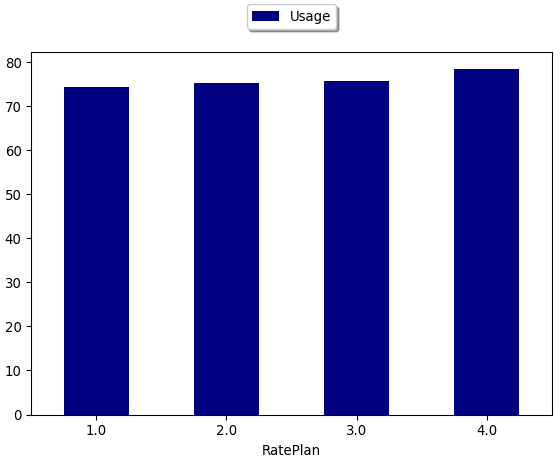

In [11]:
from pixiedust.display import *
display(data)

### Step 3: Build the Random Forest model

In [12]:
import sklearn
pd.options.display.max_columns = 999

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency,ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score

import numpy as np

import urllib3, requests, json

ModuleNotFoundError: No module named 'sklearn.cross_validation'

In [13]:
#convert CHURN to 1/0
le = LabelEncoder()
data.loc[:,'CHURN']= le.fit_transform(data.loc[:,'CHURN'])
data.head()

NameError: name 'LabelEncoder' is not defined

In [ ]:
# define the label and features
y = np.float32(data.CHURN)
x = data.drop(['CHURN'], axis = 1)

In [ ]:
# Apply the LabelEncoder to encode the input features in numeric form where applicable
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper(
    [('Gender', LabelEncoder()),
     ('Status', LabelEncoder()),
     ('Children', None),
     ('EstIncome',None),
     ('CarOwner', LabelEncoder()),
     ('Age',None),
     ('LongDistance',None),
     ('International',None),
     ('Local',None),
     ('Dropped',None),
     ('Paymethod',LabelEncoder()),
     ('LocalBilltype',LabelEncoder()),
     ('LongDistanceBilltype',LabelEncoder()),
     ('Usage',None),
     ('RatePlan',None)
    ]
)

In [ ]:
# split the data to training and testing set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# fit the model

import sklearn.pipeline
from sklearn.preprocessing import OneHotEncoder

random_forest = RandomForestClassifier()
steps = [('mapper', mapper),('RandonForestClassifier', random_forest)]
pipeline = sklearn.pipeline.Pipeline(steps)
model=pipeline.fit( X_train, y_train )
model

In [ ]:
### call pipeline.predict() on your X_test data to make a set of test predictions
y_prediction = pipeline.predict( X_test )

### test your predictions using sklearn.classification_report()

report = sklearn.metrics.classification_report( y_test, y_prediction )
### and print the report
print(report)

### Step 4: Save model to ML Repository

In [ ]:
# View the test data before saving
y_test_df = pd.DataFrame(y_test,columns=['CHURN'])
y_test_df.head()

In [ ]:
from dsx_ml.ml import save

model_name = "Telco_Churn_SKL_model"
save(model = model, name = model_name, x_test=X_test, y_test=y_test_df, algorithm_type = 'Classification')

### Step 5:  Test Saved Model with Test UI
1. Save the notebook and switch to the **Models** tab of the project (**hint**: right click the project name link, DSX_Lo, at the top, and open with another tab in your browser). 
2. Under **Models**, find and click into your saved model. 
4. Click the **Test** link to test the model. 

    You can use the following data for testing: Gender=M, Status=S, Children=0, Est Income=60000, Car Owner=Y, Age=34, LongDistance=68, International=50, Local=100, Dropped=0, Paymethod=CC, LocalBilltype=Budget, LongDistanceBilltype=Standard, Usage=334, RatePlan=3

The results of the test is displayed as follows:<br/>
<img style="float: left;" src="https://github.com/yfphoon/dsx_local/blob/master/images/Test_Model.png?raw=true" alt="Test API" width=900 />

### Step 6:  Test model with a REST API call (Optional)
This step demonstrates a REST API call to test the model. Notice that we are using DSX variables for the model endpoint and token. See documentation for external REST call syntax. 

In [15]:
json_payload = [{
    "Gender":"F",
    "Status":"M",
    "Children":2.0,
    "EstIncome":77551.100000,
    "CarOwner":"Y",
    "Age":33.600000,
    "LongDistance":20.530000,
    "International":0.000000,
    "Local":41.890000,
    "Dropped":1.000000,
    "Paymethod":"CC",
    "LocalBilltype":"Budget",
    "LongDistanceBilltype":"Standard",
    "Usage":62.420000,
    "RatePlan":2.000000
}]

In [16]:
import requests, json, os
from pprint import pprint

online_path = 'https://ibm-nginx-svc.ibm-private-cloud.svc.cluster.local/v3/project/score/Python27/scikit-learn-0.19/DSX_Local_Workshop/Telco_Churn_SKL_model/1'

header_online = {'Content-Type': 'application/json', 'Authorization':os.environ['DSX_TOKEN']}

response_scoring = requests.post(online_path, json=json_payload, headers=header_online)

response_dict = json.loads(response_scoring.content)
print("Prediction")

print(response_scoring.content)

ConnectionError: HTTPSConnectionPool(host='ibm-nginx-svc.ibm-private-cloud.svc.cluster.local', port=443): Max retries exceeded with url: /v3/project/score/Python27/scikit-learn-0.19/DSX_Local_Workshop/Telco_Churn_SKL_model/1 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f8b49e86110>: Failed to establish a new connection: [Errno -2] Name or service not known',))

In [ ]:
n = 1
for response in response_dict['object']['output']['predictions']:
    print("{}. {}".format(n,response))
    n+=1

**The prediction of 1 means that the customer will churn, and 0 that they will not churn**

You have finished working on this hands-on lab.